# Exercise 4: Circuit Decomposition
Wow! If you managed to solve the first three exercises, congratulations! The fourth problem is supposed to puzzle even the quantum experts among you, so don’t worry if you cannot solve it. If you can, hats off to you!

You may recall from your quantum mechanics course that quantum theory is unitary. Therefore, the evolution of any (closed) system can be described by a unitary. But given an arbitrary unitary, can you actually implement it on your quantum computer?

**"A set of quantum gates is said to be universal if any unitary transformation of the quantum data can be efficiently approximated arbitrarily well as a sequence of gates in the set."** (https://qiskit.org/textbook/ch-algorithms/defining-quantum-circuits.html)

Every gate you run on the IBM Quantum Experience is transpiled into single qubit rotations and CNOT (CX) gates. We know that these constitute a universal gate set, which implies that any unitary can be implemented using only these gates. However, in general it is not easy to find a good decomposition for an arbitrary unitary. Your task is to find such a decomposition.

You are given the following unitary:

In [3]:
from may4_challenge.ex4 import get_unitary
U = get_unitary()
# print(U)
print("U has shape", U.shape)

U has shape (16, 16)


#### What circuit would make such a complicated unitary?

Is there some symmetry, or is it random? We just updated Qiskit with the introduction of a quantum circuit library (https://github.com/Qiskit/qiskit-terra/tree/master/qiskit/circuit/library). This library gives users access to a rich set of well-studied circuit families, instances of which can be used as benchmarks (quantum volume), as building blocks in building more complex circuits (adders), or as tools to explore quantum computational advantage over classical computation (instantaneous quantum polynomial complexity circuits).

In [4]:
from qiskit import QuantumCircuit
from may4_challenge.ex4 import check_circuit, submit_circuit

#additional deps for learning and exploring the problem
%matplotlib inline

from qiskit import *
from qiskit.quantum_info import Operator
import numpy as np
import scipy as scipy
import sympy as sym
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from qiskit.transpiler.passes import Unroller
from qiskit.transpiler import PassManager
from qiskit.extensions import UnitaryGate
from scipy.ndimage.interpolation import rotate
from may4_challenge.ex4 import check_circuit, submit_circuit
from scipy.linalg import hadamard
import math
from cmath import rect
from sympy.physics.quantum.state import *
from IPython.display import display, Math, HTML, display_latex
from qiskit.visualization import plot_gate_map
from qiskit.tools.visualization import *

sym.init_printing()
%config InlineBackend.figure_format = 'retina' # to print nice and crisp graphs. believe me.
display(HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
    align-items: center;
}
</style>
"""))

**Using only single qubit rotations and CNOT gates, find a quantum circuit that approximates that unitary $U$ by a unitary $V$ up to an error $\varepsilon = 0.01$, such that $\lVert U - V\rVert_2 \leq \varepsilon$ !** 

Note that the norm we are using here is the spectral norm, $\qquad \lVert A \rVert_2 = \max_{\lVert \psi \rVert_2= 1} \lVert A \psi \rVert$.

This can be seen as the largest scaling factor that the matrix $A$ has on any initial (normalized) state $\psi$. One can show that this norm corresponds to the largest singular value of $A$, i.e., the square root of the largest eigenvalue of the matrix $A^\dagger A$, where $A^{\dagger}$ denotes the conjugate transpose of $A$.

**When you submit a circuit, we remove the global phase of the corresponding unitary $V$ before comparing it with $U$ using the spectral norm. For example, if you submit a circuit that generates $V = \text{e}^{i\theta}U$, we remove the global phase $\text{e}^{i\theta}$ from $V$ before computing the norm, and you will have a successful submission. As a result, you do not have to worry about matching the desired unitary, $U$, up to a global phase.**

As the single-qubit gates have a much higher fidelity than the two-qubit gates, we will look at the number of CNOT-gates, $n_{cx}$, and the number of u3-gates, $n_{u3}$, to determine the cost of your decomposition as 

$$
\qquad \text{cost} = 10 \cdot n_{cx} + n_{u3}
$$

Try to optimize the cost of your decomposition. 

**Note that you will need to ensure that your circuit is composed only of $u3$ and $cx$ gates. The exercise is considered correctly solved if your cost is smaller than 1600.**

---
For useful tips to complete this exercise as well as pointers for communicating with other participants and asking questions, please take a look at the following [repository](https://github.com/qiskit-community/may4_challenge_exercises). You will also find a copy of these exercises, so feel free to edit and experiment with these notebooks.

---

# Solution:

let's define some helper functions and constants to get rid of some code further down

In [167]:
num_qbit = 4
num_qbit_list = list(range(num_qbit))

H = 1/np.sqrt(2)*np.array([[1,1],[1,-1]]) # 1 qubit Hadamard
H4 = np.kron(H,np.kron(H,np.kron(H,H))) # 4 qbuit Hadamard
# The above is for learning purposes. In real life you'd use some helper like the following
# we divide it by 4 to normalize it.
# H4 = hadamard(16, dtype=complex)/4

U_simulator = Aer.get_backend('unitary_simulator')

def plot_matrix(mat, plot_type='default'):
    if plot_type == 'heatmap' or plot_type == 'default' or plot_type == 'all':
        fig, axs = mpl.pyplot.subplots(1, 2, figsize=(20, 8))
        im1 = axs[0].imshow(np.abs(mat), cmap='hot', interpolation='bilinear', vmin=0, vmax=1)
        axs[0].set_title('Magnitude')
        fig.colorbar(im1, ax=axs[0])
        im2 = axs[1].imshow(np.angle(mat), cmap='hot', interpolation='bilinear', vmin=-np.pi, vmax=np.pi)
        axs[1].set_title('Phase')
        fig.colorbar(im2, ax=axs[1])

    if plot_type == 'sns' or plot_type == 'all':
        fig, ax = mpl.pyplot.subplots(1, 2, figsize=(20, 8))
        sns.heatmap(np.abs(mat), annot=True, fmt = '0.2f', linewidths=.5, ax=ax[0])
        ax[0].set_title('Magnitude')
        sns.heatmap(np.angle(mat), annot=True, fmt = '0.2f', linewidths=.5, ax=ax[1])
        ax[1].set_title('Phase')
    
    mpl.pyplot.show()
    
    #fig1, ax1 = mpl.pyplot.subplots(figsize=(10,10))
    #sns.heatmap(np.abs(mat), annot=True, fmt = '0.2f', linewidths=.5, ax=ax1)
    #mpl.pyplot.show()
    #fig2, ax2 = mpl.pyplot.subplots(figsize=(20,20))
    #U2_1 = rotate(mat.real, angle=45)
    #U2_2 = rotate(mat.imag, angle=45)
    #U2 = U2_1 + 1j*U2_2
    #M2 = np.absolute(U2)
    #sns.heatmap(M2, annot =True, fmt = '0.2f', linewidths=.5, ax=ax2)

def plot_circuit(qc):
    plot_matrix(Operator(qc).data)

def gen_table(data, collabel, figsize, font_size, table_scale):
    fig = plt.figure(figsize=figsize, linewidth=1)#dpi=200
    ax = fig.add_subplot(1,1,1)
    mpl.rcParams['mathtext.fontset'] = 'cm'
    mpl.rcParams['mathtext.rm'] = 'serif'
    table = ax.table(cellText=table_data, colLabels=collabel, loc='center')
    plt.rc('lines', linewidth=3)
    table.set_fontsize(font_size)
    table.scale(table_scale[0], table_scale[1])
    ax.axis('off')

# Reference: https://github.com/zjiang23/CS269Q-RQSS/blob/master/qft.py
# Reference: https://courses.edx.org/c4x/BerkeleyX/CS191x/asset/chap5.pdf (Page 2)
def QFT_mat2(n):
    omega = np.exp(2.0 * np.pi * 1j / n)
    mat = np.ones((n, n), dtype=complex)
    
    for i in range(1, n):
        for j in range(1, n):
            mat[i, j] = omega ** (i * j)

    mat /= math.sqrt(float(n))
    return mat

def QFT_mat(n):
    NN = 2**n
    QFN = np.zeros([NN,NN],dtype=np.complex_)
    for i in range(NN):
        for j in range(NN):
            if (i == 0) or (j == 0):
                QFN[i,j] = 1
            else:
                QFN[i,j] = np.exp((2*np.pi*1j)*(i*j)/NN)
    return QFN

# The following for loop is to replace very small values ( < 1e-14) from computational error with zero,
# this way when calculating the phase we will get zero rather than random values
def filter_mat(m):
    m_ret = np.zeros(shape=m.shape, dtype=m.dtype)
    for i in range(len(m)):
        for j in range(len(m[i])):
            m_ret[i,j] = m[i,j]
            if 0 < np.real(m_ret[i,j]) < 1e-14:
                m_ret[i,j] = 0 + 1j*(np.imag(m_ret[i,j]))
            if -1e-14 < np.real(m_ret[i,j]) < 0:
                m_ret[i,j] = 0 + 1j*(np.imag(m_ret[i,j]))
            if 0 < np.imag(m_ret[i,j]) < 1e-14:
                m_ret[i,j] = np.real(m_ret[i,j]) + 1j*0
            if -1e-14 < np.imag(m_ret[i,j]) < 1e-14:
                m_ret[i,j] = np.real(m_ret[i,j]) + 1j*0
    return m_ret

def rad_sum(a, b):
    sinAB = sym.sin(a) * sym.cos(b) + sym.cos(a) * sym.sin(b)
    cosAB = sym.cos(a) * sym.cos(b) - sym.sin(a) * sym.sin(b)
    return sym.atan2(sinAB, cosAB)

real2rational = np.vectorize(sym.Rational)
vnsimplify = np.vectorize(sym.nsimplify, excluded=['constants'])
m_rad_sum = np.vectorize(rad_sum)

def real2rationalPI(m):
    ret = m/np.pi # divide by pi to help to rationalize
    ret = real2rational(ret)
    ret = ret * np.pi # add pi back
    return ret

Let's try to break down what we need to do in order to have a starting point where the check_circuit function happily validates our input.
1. Create a quantum circuit
2. Append the Unitary matrix to it
3. Transpile (aka "translate") it in order to have only u3 and cx gates as per requested
4. Pass it to the check_circuit function

Questions are:
1. Why do we need to transpile/optimize our circuit?  
 Depending on the quantum computer you're going to select as your backend you might or might not have certain gates available. 
 This is known as available `native gate set`.  
 We need therefore to "translate" our circuit in a set of gates our quantum computer features.
 
 Moreover if we try and plot Vigo backend `gate map` as instance, we can see there cannot be interactions between gate 2 and gates other than 1. Also 0 cannot interact with 4 and so on.

 You can find more info here: https://qiskit.org/documentation/stubs/qiskit.compiler.transpile.html

ibmqfactory.load_account:WARNING:2020-05-20 13:16:45,061: Credentials are already in use. The existing account in the session will be replaced.


backend native gate set: ['u1', 'u2', 'u3', 'cx', 'id']


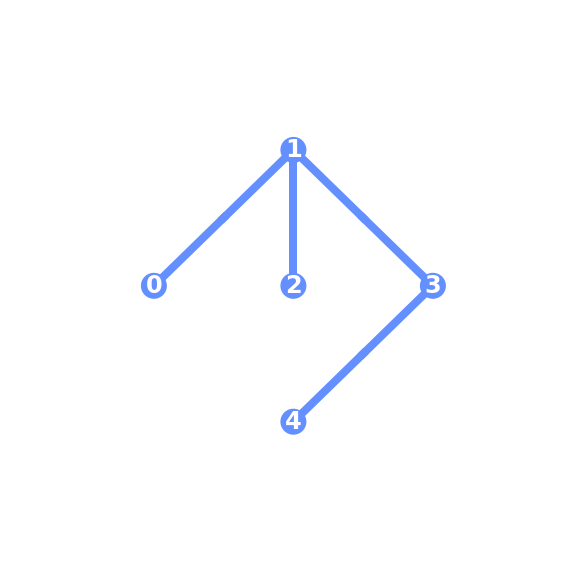

In [174]:
provider = IBMQ.load_account()
accountProvider = IBMQ.get_provider(hub='ibm-q')
backend = accountProvider.get_backend('ibmq_vigo')
backend_configuration = backend.configuration()
backend_properties = backend.properties()
print("backend native gate set: {}".format(backend_configuration.basis_gates))
plot_gate_map(backend)

2. What is an Unitary matrix anyway? What other kind of matrix exists?  
 An answer can be found here: http://fourier.eng.hmc.edu/e161/lectures/algebra/node4.html  
 `A matrix is a unitary matrix if its conjugate transpose is equal to its inverse`  
 Ok, let's check this:

In [165]:
u_conj_transpose = U.transpose().conj()
u_inverse = np.power(U, -1)
# u_inverse = np.power(u_conj_transpose, -1) # this doesn't work either
(u_inverse == u_conj_transpose).all()

False

  Well, that's interesting... Thoughts? Please provide feedbacks so I can update this with an explaination.
  Let's move forward.  
  Why are we presented an Unitary matrix and what does it have anything to do with Quantum Computing?  
  A use case could be a smart Chemistry guy translated his molecule problem into a Unitary matrix and he needs you to give him back QC results.  
  Another one could be for financial predictions.
3. How do we append an Unitary matrix to a circuit?
 Well this depends on its properties. Let's see how this matrix looks like

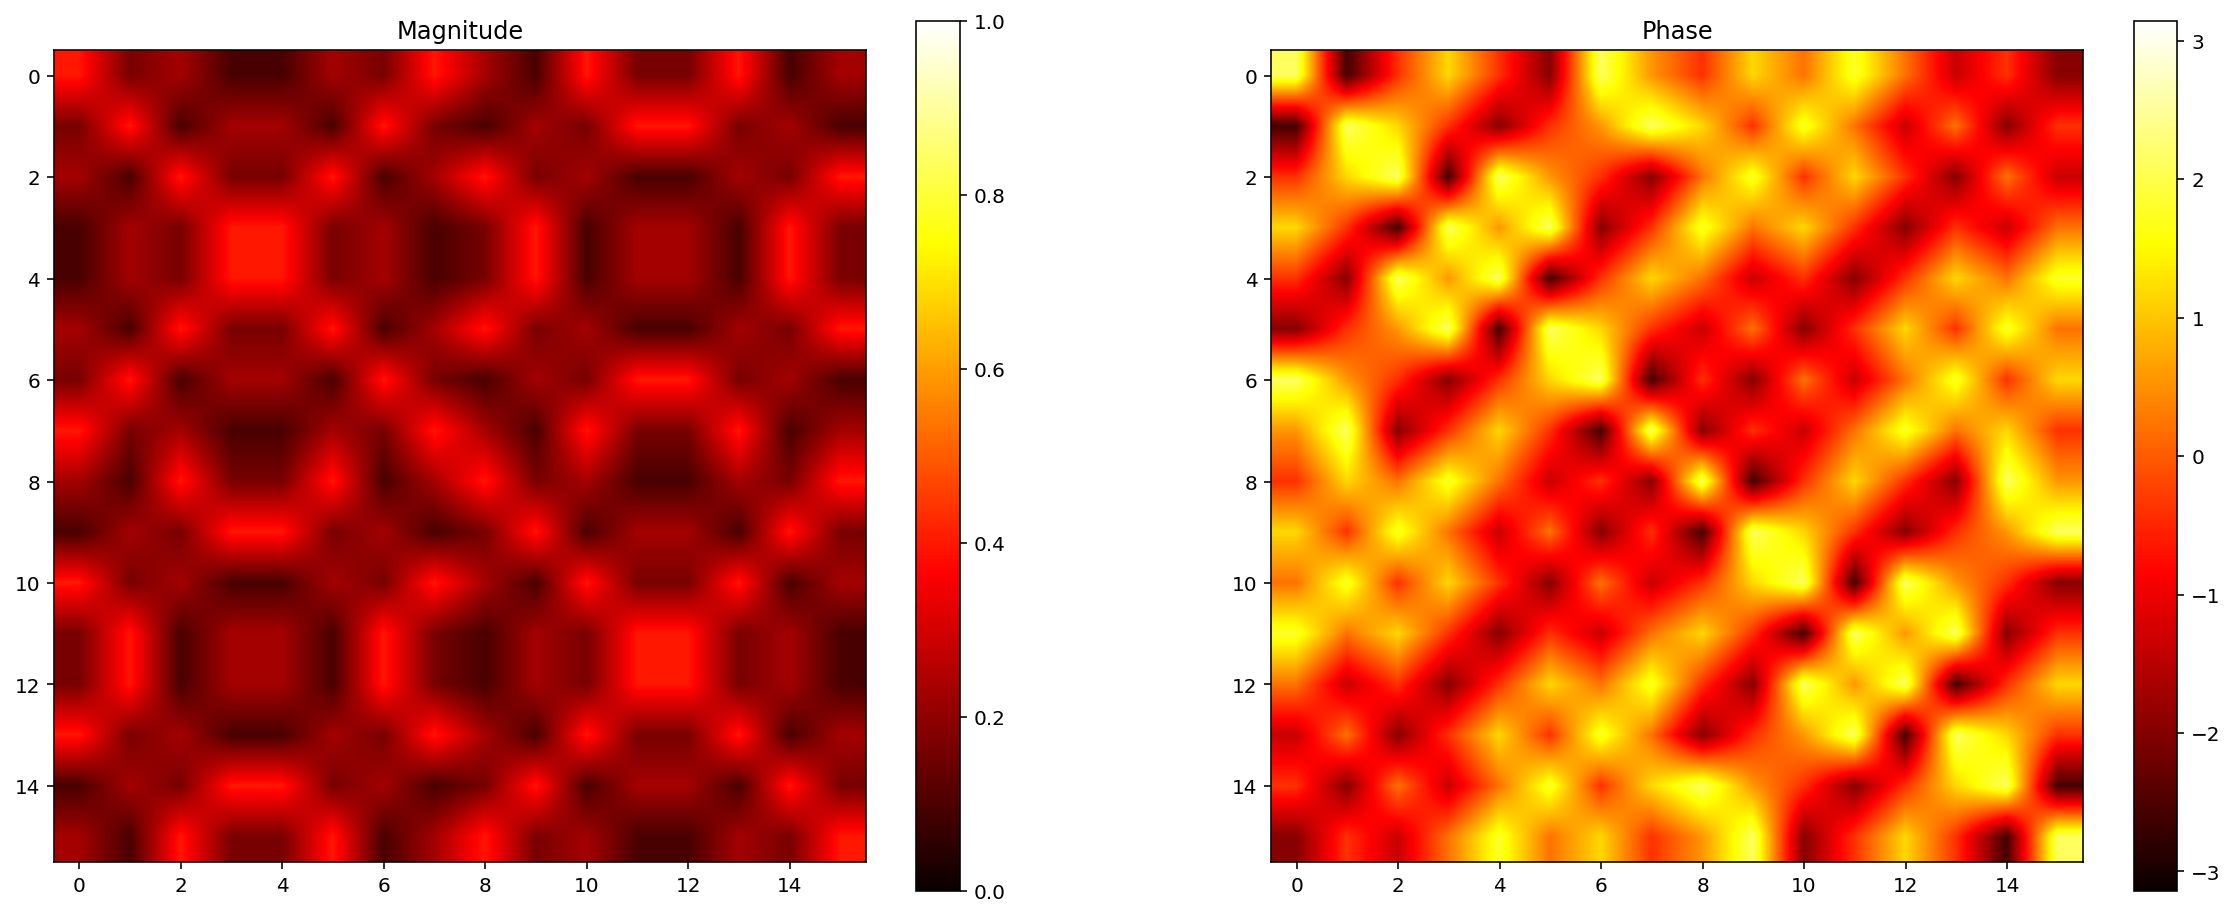

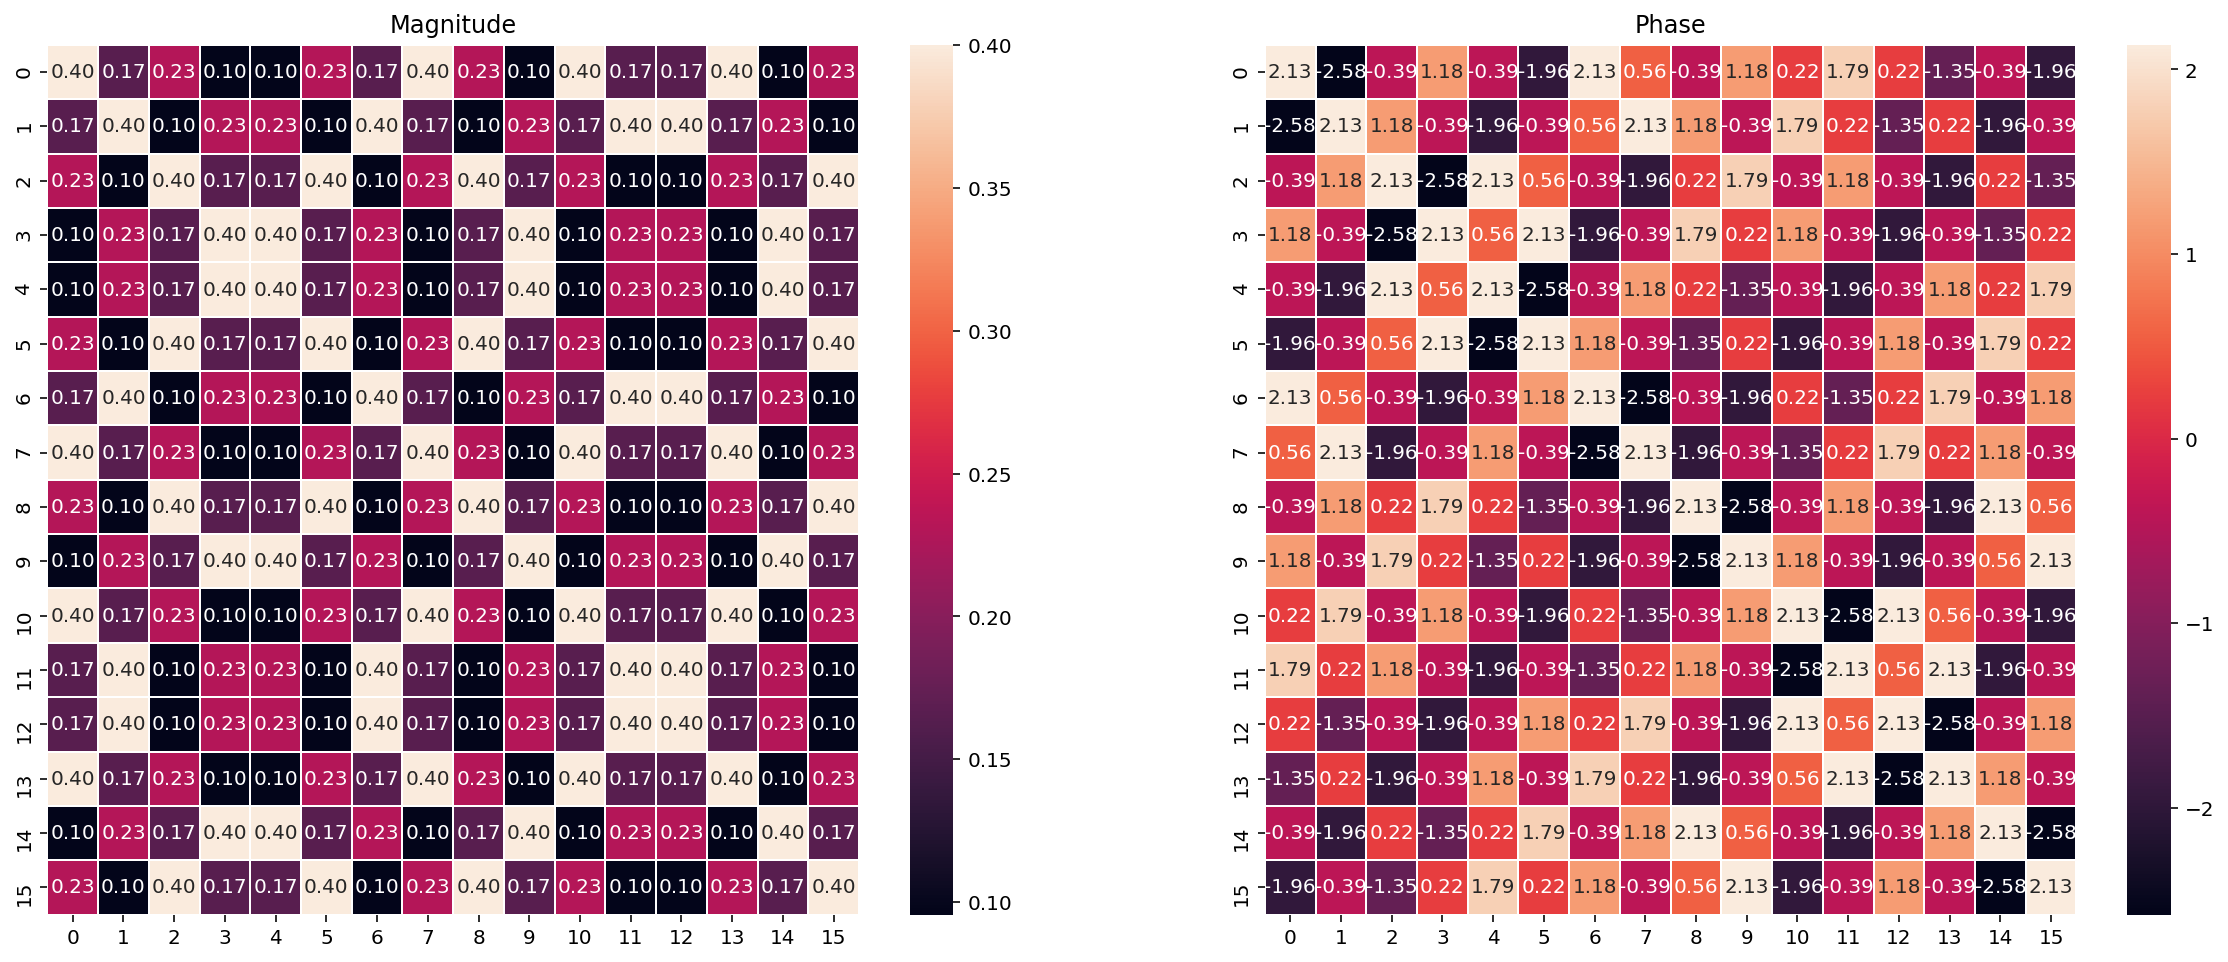

In [97]:
plot_matrix(U, plot_type='all')

If you notice you can see that if you fold it in half across its diagonal (top-left to bottom right) you have values which are touching their corresponding one on the other side.  
As if in the middle there was a mirror.  
This is called an 'isometry' https://en.wikipedia.org/wiki/Isometry
Maybe there's a way to append an isometry to a quantum circuit in Qiskit.  
If you google "qiskit isometry" you'll certainly find this: https://qiskit.org/documentation/stubs/qiskit.circuit.QuantumCircuit.isometry.html (.iso() and .isometry() are the same function)  
So let's try to append this isometric matrix to our quantum circuit and let's see what we come up with:

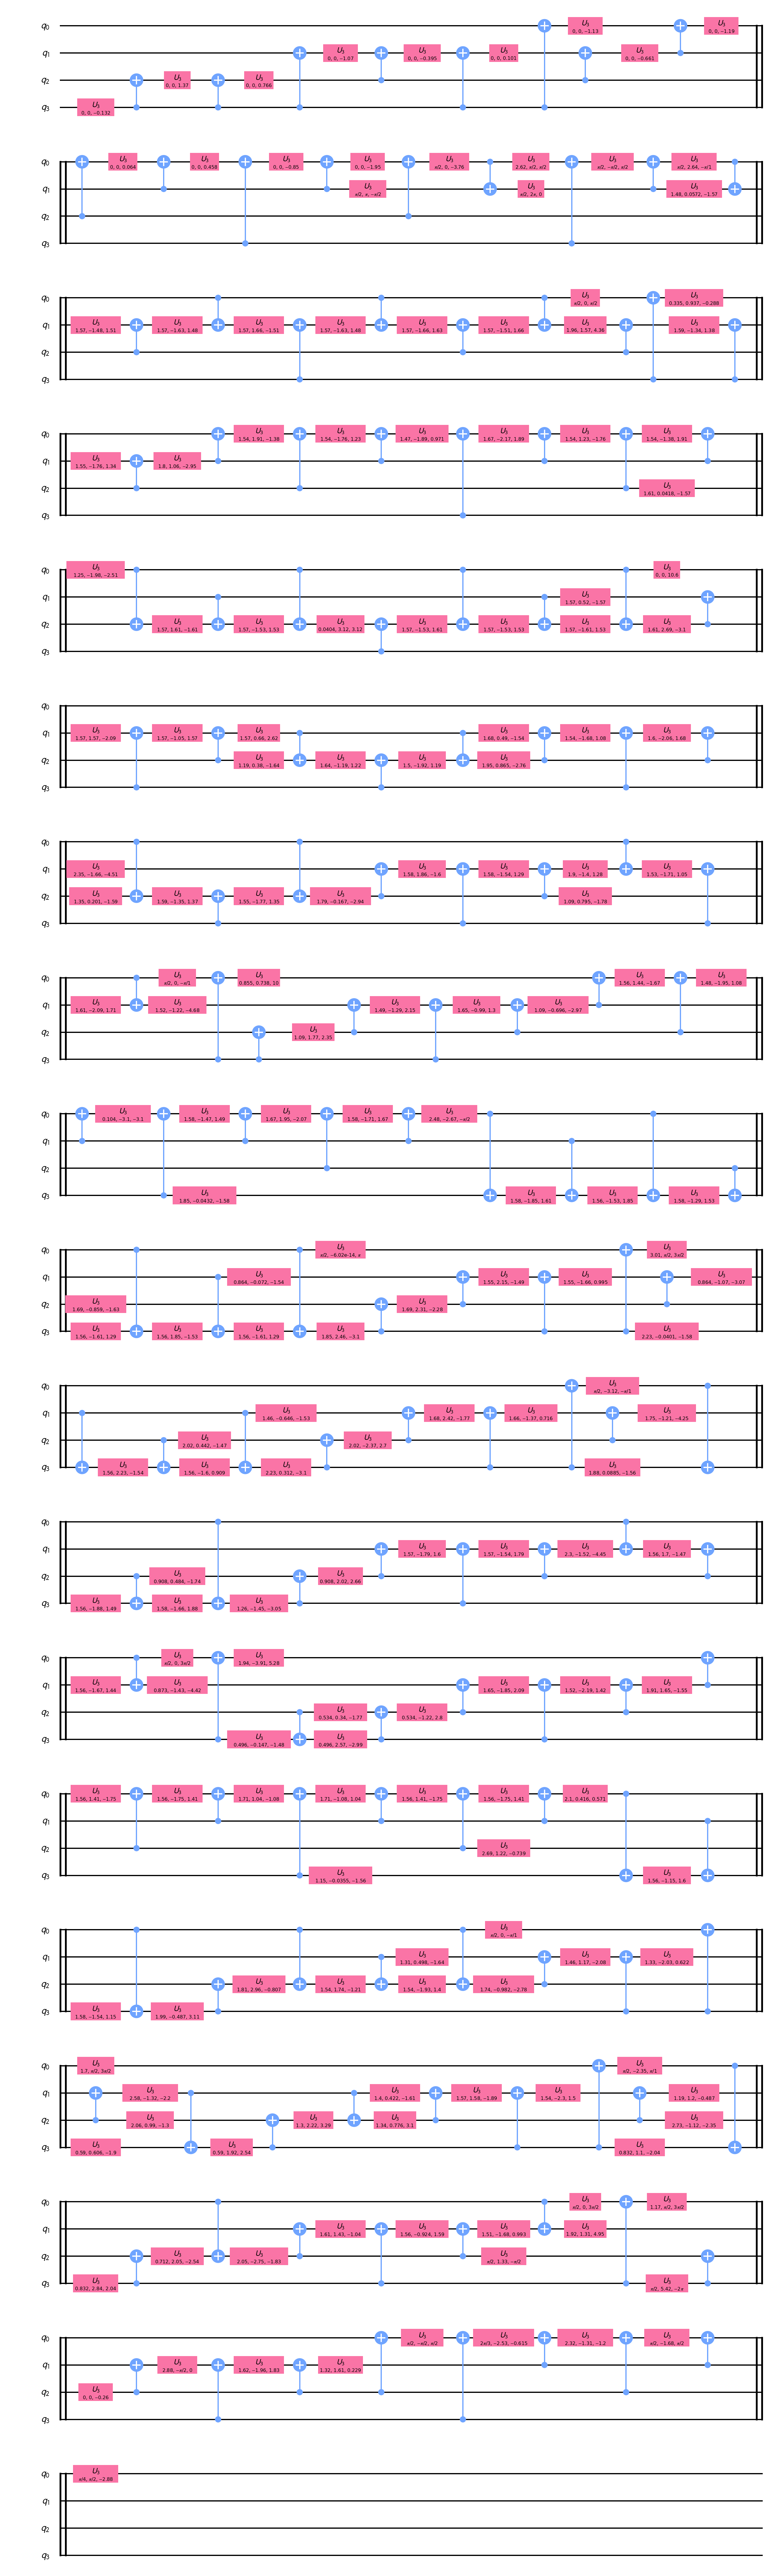

In [101]:
def unoptimized():
    # 1. Create a quantum circuit
    qc = QuantumCircuit(4)
    # 2. Append the unitary matrix to it
    qc.iso(U,[0,1,2,3],[])
    # 3. Transpile (aka "translate") it in order to have only u3 and cx gates as per requested
    qc_transpiled = transpile(qc, basis_gates=['u3','cx'], optimization_level=3)
    return qc_transpiled

qc = unoptimized()
qc.draw(output='mpl')

Wow this circuit it's massive! Let's check how's the situation:

In [102]:
# 4. Pass it to the check_circuit function
check_circuit(qc)

Circuit stats:
||U-V||_2 = 2.737294473846746e-12
(U is the reference unitary, V is yours, and the global phase has been removed from both of them).
Cost is 1676

Something is not right with your circuit: the cost of the circuit is too high (above 1600)


Ok at least we have a starting point. Nice, can we do the same thingy we did in exercise 1? Sure!

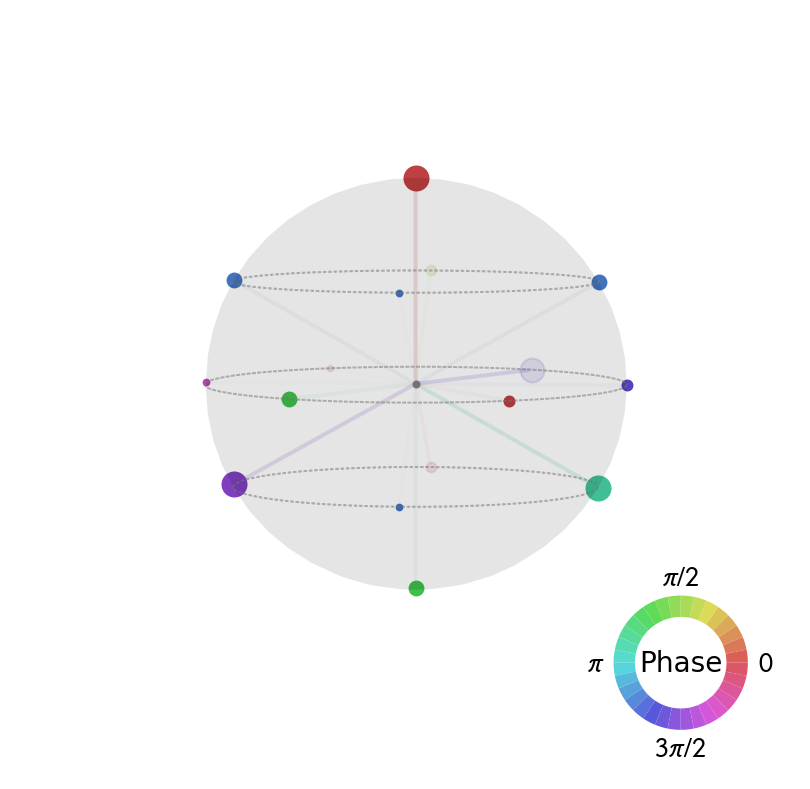

In [103]:
backend = BasicAer.get_backend('statevector_simulator')
result = execute(qc, backend).result()
psi = result.get_statevector(qc)
plot_state_qsphere(psi)

How about the bloch sphere of each qbit?

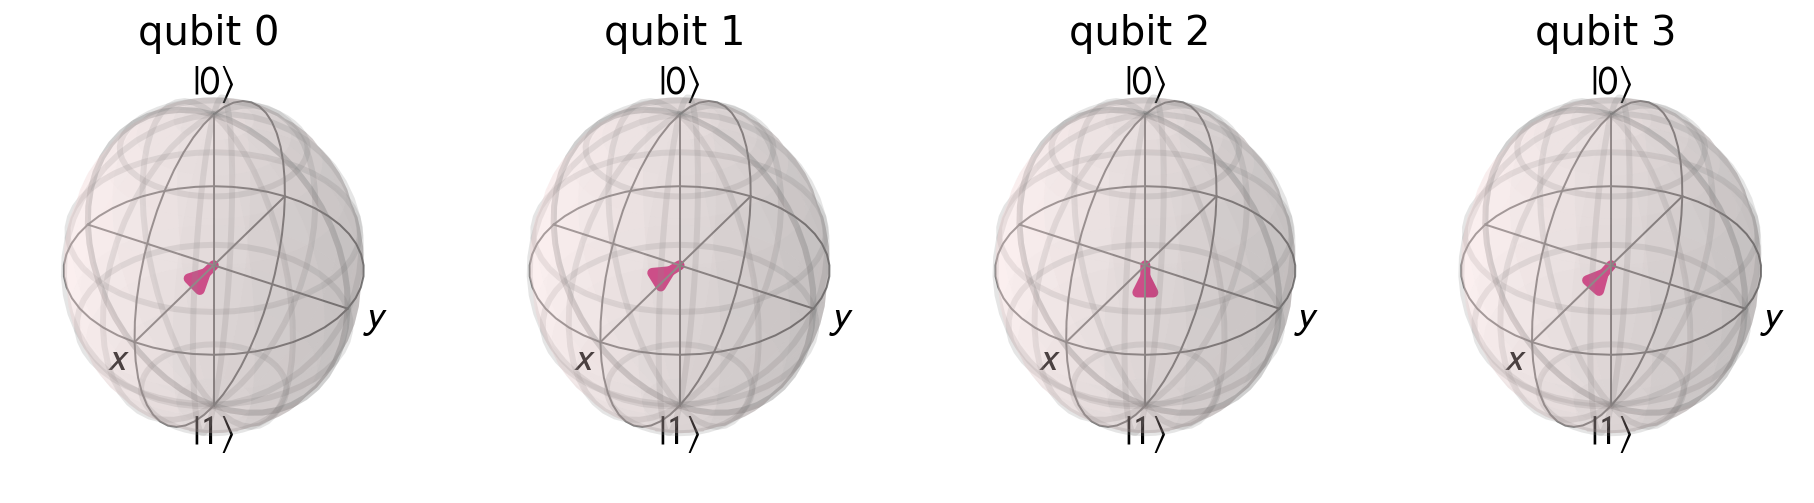

In [104]:
plot_bloch_multivector(psi)

Anyway, we need to chunk this down. Solution to ex3 tells us to use solution from ex1.  
[104, 52, 100, 97, 109, 65, 114, 100]  
Let's convert this into ASCII chars:

In [205]:
solution_ex1 = [104, 52, 100, 97, 109, 65, 114, 100]
"".join([chr(char) for char in solution_ex1])

'h4damArd'

Hadamard, ok. Let's throw it in the circuit to see what happens:

In [169]:
def optimized1():
    qc = QuantumCircuit(4)
    HU = np.matmul(H4, U)
    qc.iso(HU,num_qbit_list,[])
    qc.h(num_qbit_list)
    qc_t = transpile(qc, basis_gates=['u3','cx'], optimization_level=3)
    return qc_t

qc = optimized1()
check_circuit(qc)

Circuit stats:
||U-V||_2 = 7.395610330596521e-08
(U is the reference unitary, V is yours, and the global phase has been removed from both of them).
Cost is 1449

Great! Your circuit meets all the constrains.
Your score is 1449. The lower, the better!
Feel free to submit your answer and remember you can re-submit a new circuit at any time!


Great! Our circuit meets all the constrains.  
If you got this far during the challenge and you feel like calling it a day you can stop here and submit your answer.
This is what I did because I'm new to this discipline and I already considered it a miracle.
But let's see if we can improve on minimum requirements and learn something from other people.

From here onward we can take a look at the approach Diego Emilio Serrano used to get one of the lowest score which amounts to 46. You can find his solution here https://github.com/diemilio/IBM_2020Challenge_Solutions/blob/master/Challenge4_CircuitDecomposition_Solution.ipynb  
There were few points I had trouble following due to my lack of knowledge so I integrated here what helped me developing some intuition about his reasoning.

As instance he suggests at this point to take a look at the unitary matrix in Fourier space, to see if we notice anything interesting in what you can think of its "composing frequencies":

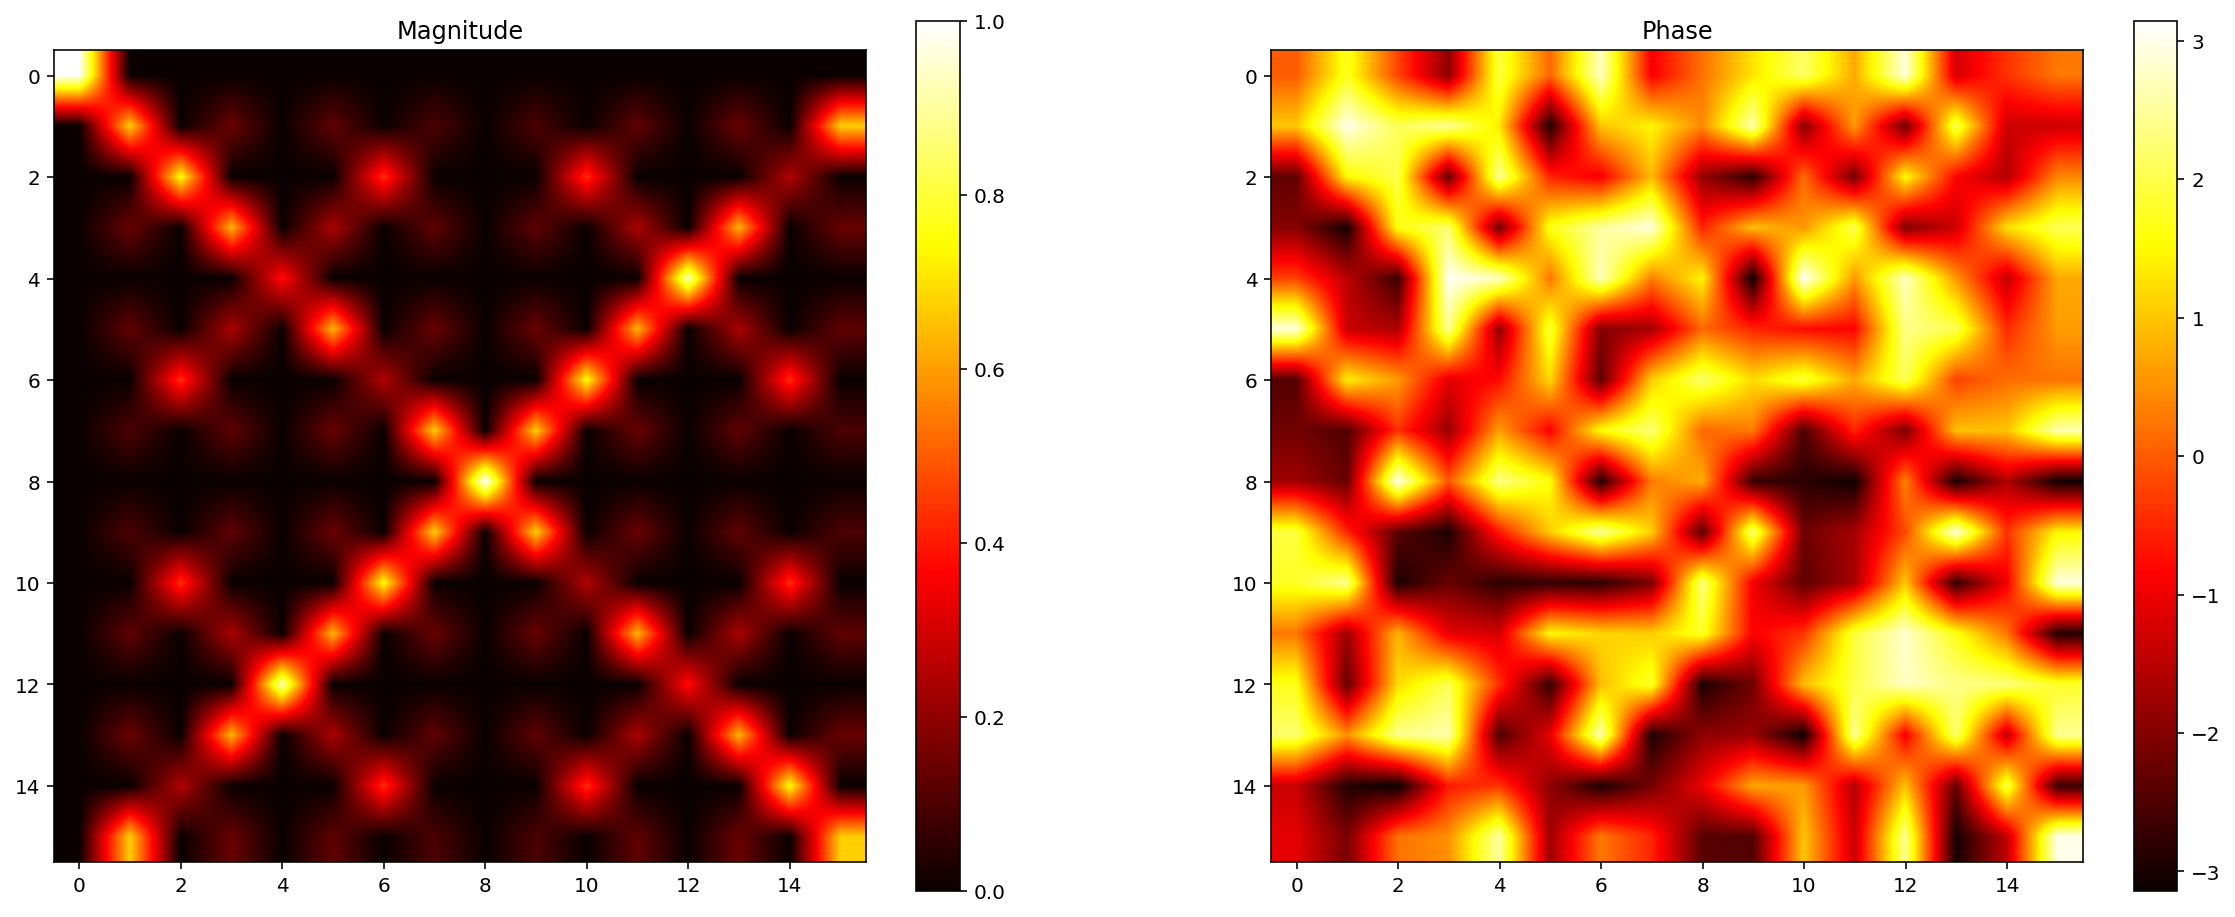

In [185]:
QF4 = QFT_mat(4) # 4 qubit QFT matrix
QF4_inv = np.linalg.inv(QF4) # 4 qubit inverse QFT matrix
QUQ = np.matmul(QF4_inv,np.matmul(U,QF4))
plot_matrix(QUQ, plot_type='heatmap')

mmm... Phase graph is on fire. Let's denoise it a bit by removing negligible values

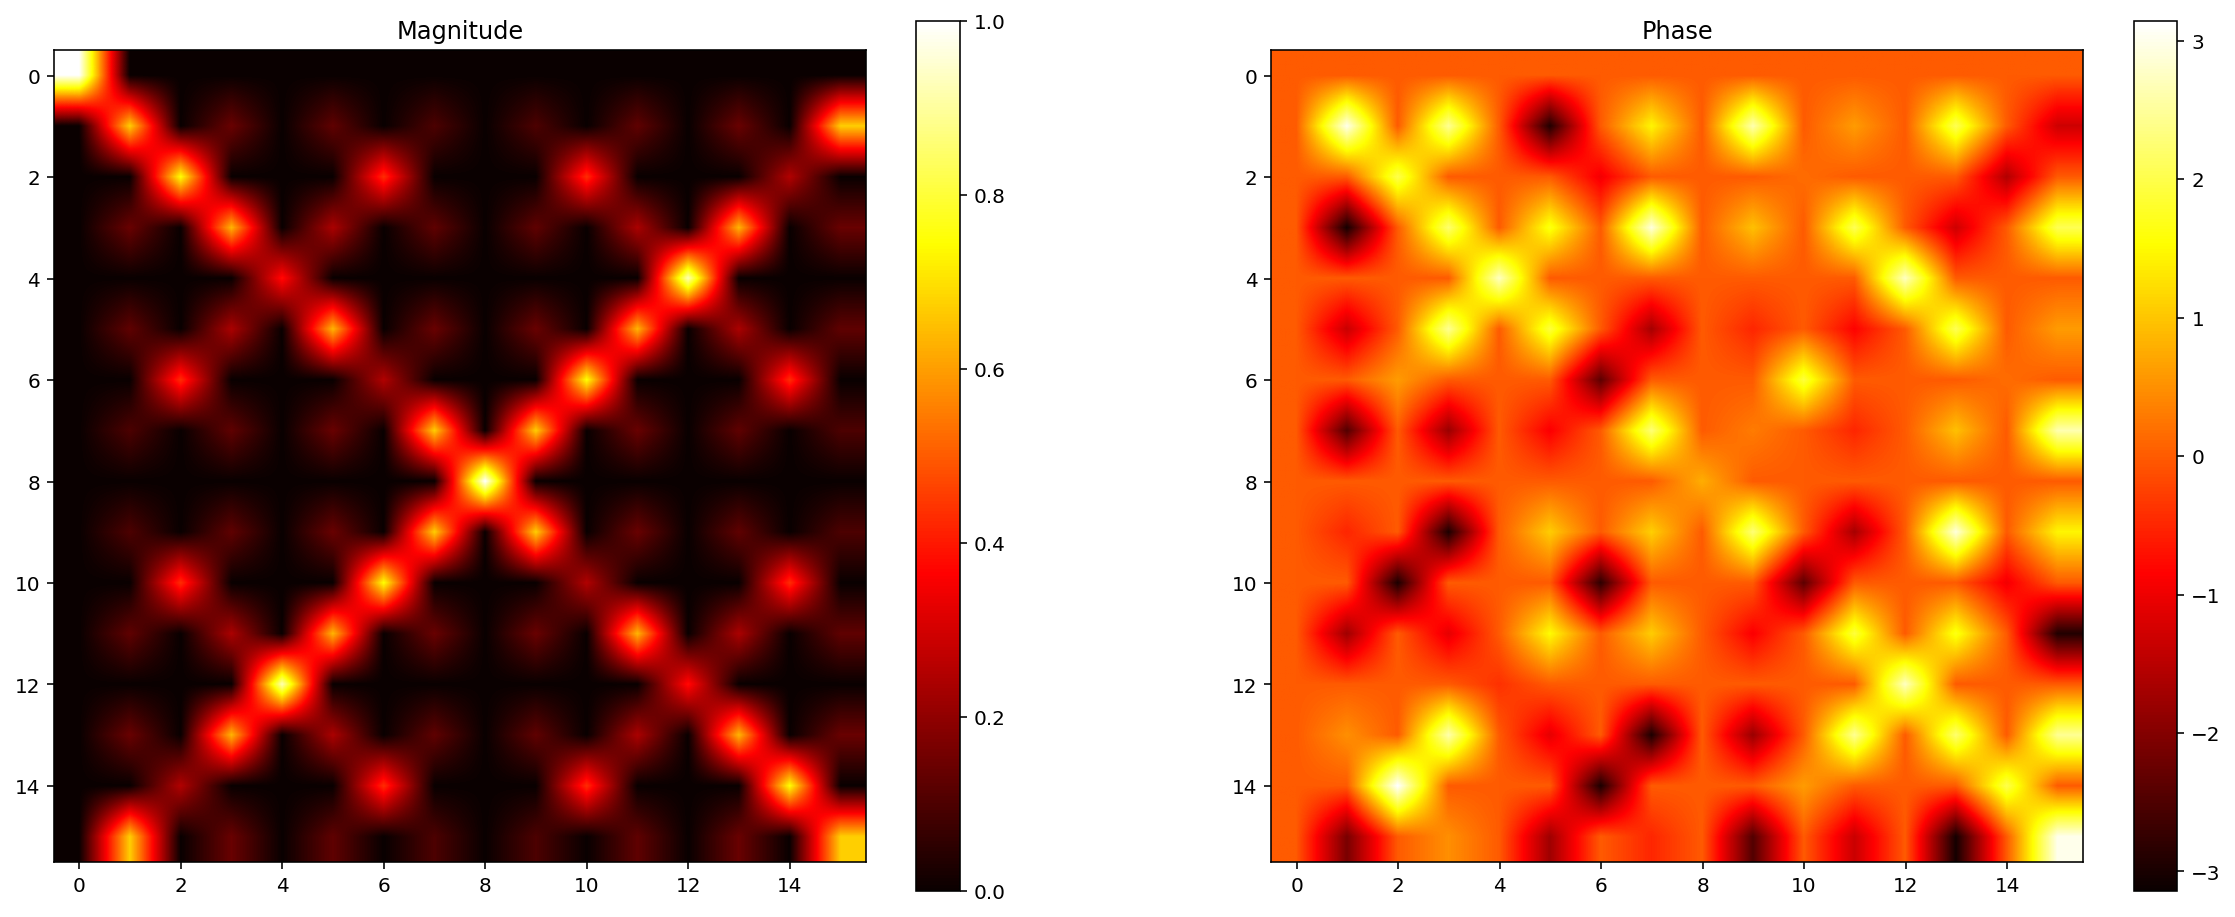

In [181]:
QUQ.real[abs(QUQ.real) < 1e-14] = 0.0
QUQ.imag[abs(QUQ.imag) < 1e-14] = 0.0
plot_matrix(QUQ, plot_type='heatmap')

Looks better. We can clearly see values across diagonals being highlighted.  
So let's try to throw in the mix the Hadamard Gate as before and see what happens.

In [170]:
def optimized2():
    UH = np.matmul(U,H4)
    UH.real[abs(UH.real) < 1e-14] = 0.0
    UH.imag[abs(UH.imag) < 1e-14] = 0.0
    
    qc = QuantumCircuit(num_qbit)
    qc.h(num_qbit_list)
    qc.iso(UH, num_qbit_list, [])
    qc_t = transpile(qc, basis_gates = ['u3', 'cx'], optimization_level=2,)
    
    return qc_t

qc = optimized2()
check_circuit(qc)

Circuit stats:
||U-V||_2 = 7.31201725589293e-15
(U is the reference unitary, V is yours, and the global phase has been removed from both of them).
Cost is 351

Great! Your circuit meets all the constrains.
Your score is 351. The lower, the better!
Feel free to submit your answer and remember you can re-submit a new circuit at any time!


Good, let's try and improve on this. We do it by moving it in Hadarmad space. In other terms we apply Hadamard gates before and after our circuit to give a chance to the optimizer to do its magic

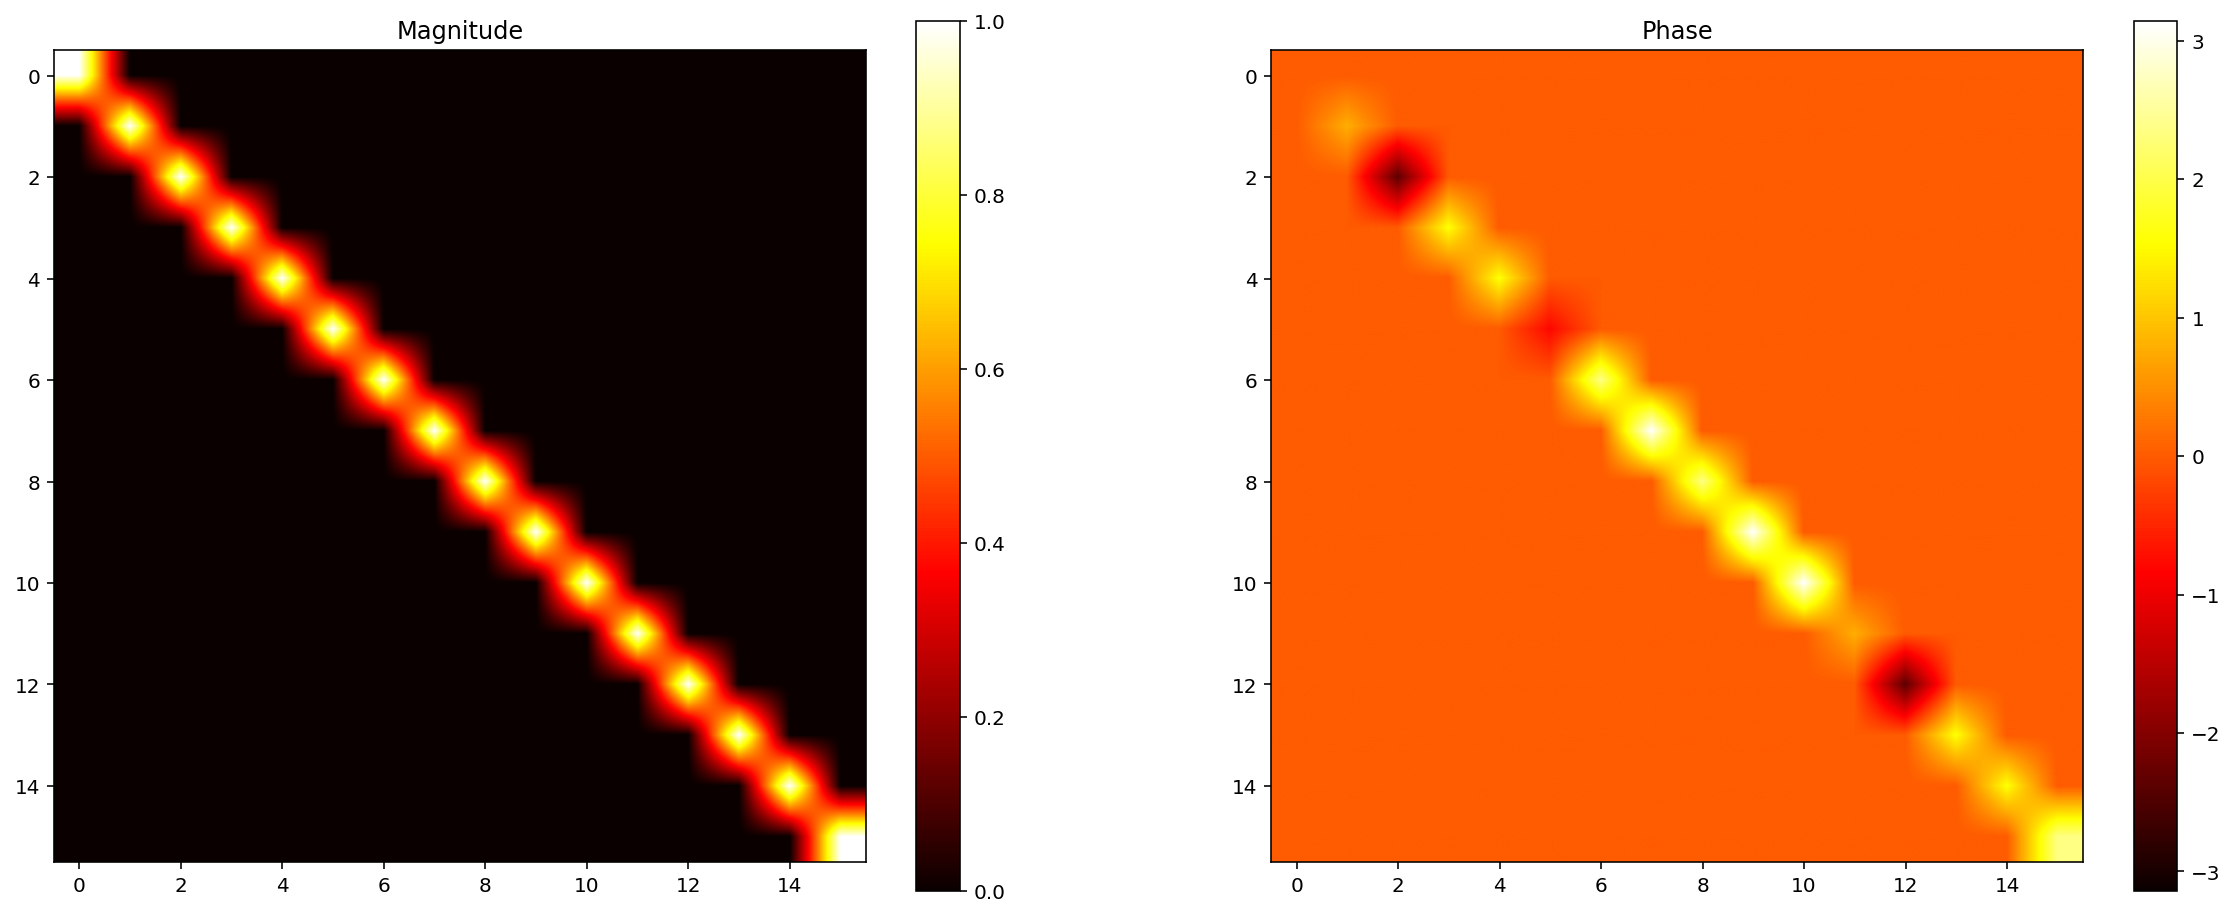

In [171]:
UH = np.matmul(U,H4)
HUH = np.matmul(H4,UH)
HUH.real[abs(HUH.real) < 1e-14] = 0.0
HUH.imag[abs(HUH.imag) < 1e-14] = 0.0
plot_matrix(HUH, 'default')

In [172]:
def optimized3():    
    qc = QuantumCircuit(num_qbit)
    qc.h(num_qbit_list)
    qc.iso(HUH, num_qbit_list, [])
    qc.h(num_qbit_list)
    qc_t = transpile(qc, basis_gates = ['u3', 'cx'], optimization_level=3)
    
    return qc_t

qc = optimized3()
check_circuit(qc)

Circuit stats:
||U-V||_2 = 6.445258714242848e-15
(U is the reference unitary, V is yours, and the global phase has been removed from both of them).
Cost is 107

Great! Your circuit meets all the constrains.
Your score is 107. The lower, the better!
Feel free to submit your answer and remember you can re-submit a new circuit at any time!


can we do better than this? Yeah, but we need some theory.
Let's consider a unitary similar to ours but simpler; with only 2 qbits:

In [162]:
test_unitary_raw = np.matrix([
    [1, 0, 0, 0],
    [0, -1, 0, 0],
    [0, 0, (1/np.sqrt(2))*(1+1j), 0],
    [0, 0, 0, 1]
])
test_unitary = vnsimplify(test_unitary_raw, constants=[sym.sqrt(2)])
display(sym.Matrix(test_unitary))

⎡1  0       0      0⎤
⎢                   ⎥
⎢0  -1      0      0⎥
⎢                   ⎥
⎢       √2   √2⋅ⅈ   ⎥
⎢0  0   ── + ────  0⎥
⎢       2     2     ⎥
⎢                   ⎥
⎣0  0       0      1⎦

We focus on its diagonal because we're interested in mapping single qbits transitions so we can have a sort of truth table.  
So for its diagonal

In [8]:
test_unitary_diagonal_raw = np.diagonal(test_unitary_raw)
test_unitary_diagonal = vnsimplify(test_unitary_diagonal_raw, constants=[sym.sqrt(2)])
display(sym.Array(test_unitary_diagonal))

⎡       √2   √2⋅ⅈ   ⎤
⎢1  -1  ── + ────  1⎥
⎣       2     2     ⎦

We get the following truth table

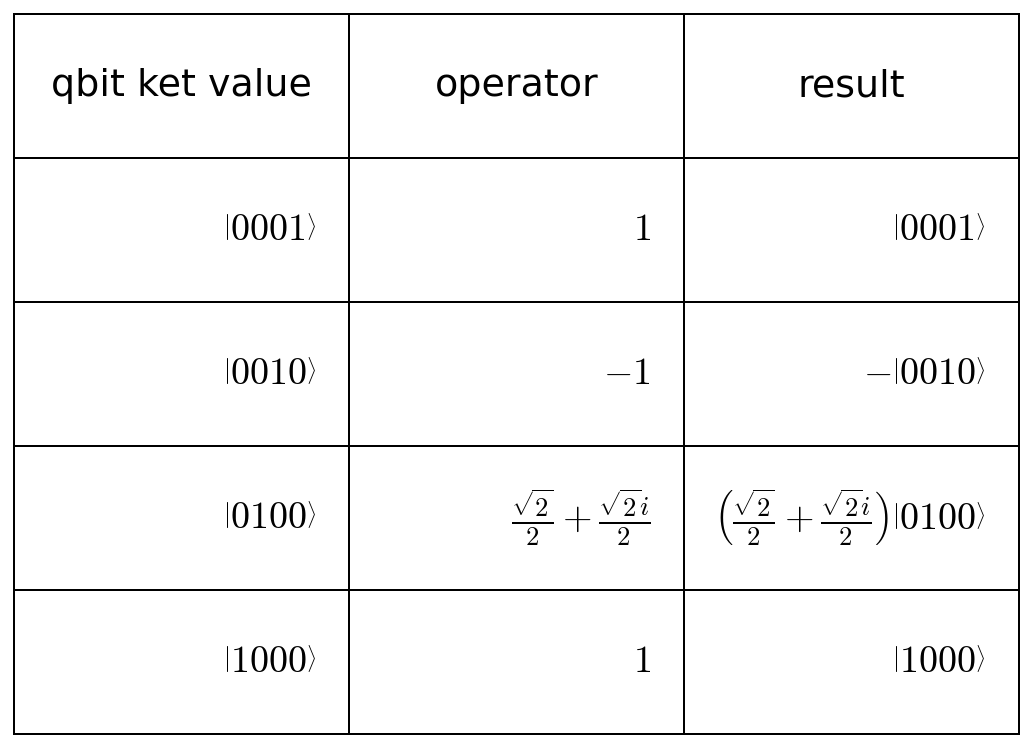

In [9]:
table_data = []

for idx, operator in enumerate(test_unitary_diagonal):
    ketval = 0b1 << idx
    ket_args = [int(x) for x in '{:04b}'.format(ketval)]
    ket_val = Ket(*ket_args)
    ket_val_latex = r"${}$".format(sym.latex(ket_val))
    operator_latex = r"${}$".format(sym.latex(operator))
    result_latex = r"${}$".format(sym.latex(operator * ket_val))
    table_data.append([ket_val_latex, operator_latex, result_latex])

collabel=("qbit ket value", "operator", "result")
gen_table(table_data, collabel, figsize=(3,6), font_size=20, table_scale=(3,6))

plt.show()

#display(Math(sym.latex(Ket(1, 2))))
#display(Math(sym.latex(test_circuit_unitary_diagonal[0])))
#display(sym.Rational(sym.N(test_circuit_unitary_diagonal[0])))
#display(sym.dsolve(sym.N(test_circuit_unitary_diagonal[0])))

Or we can say we add the following relative phase to each state

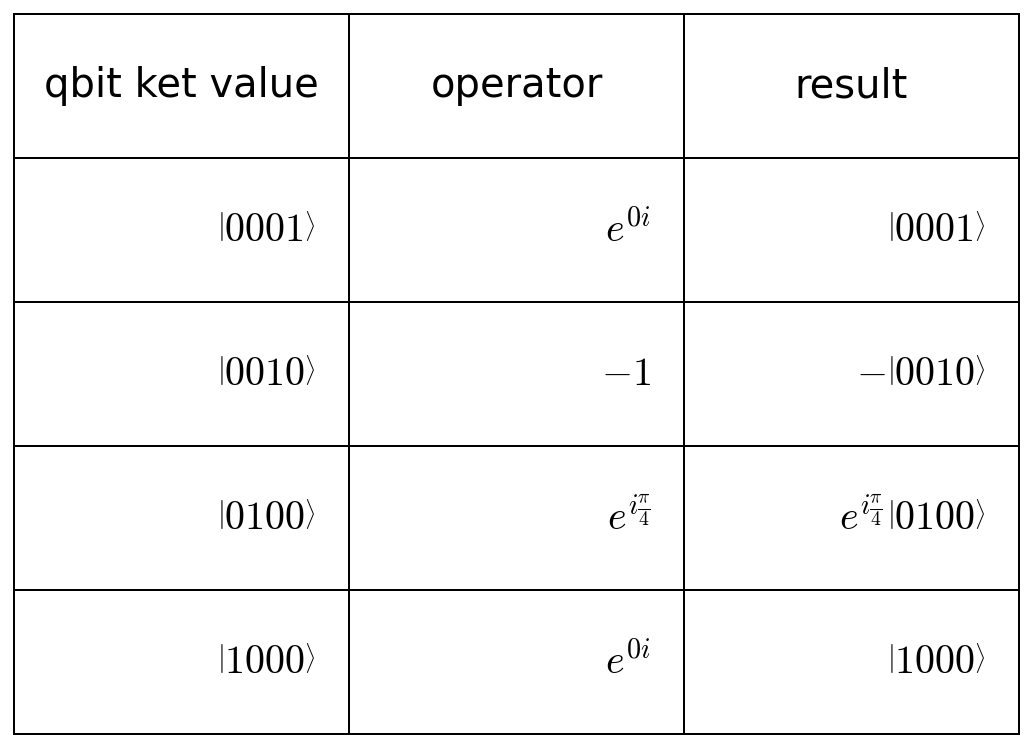

In [10]:
table_data = []

test_unitary_diagonal_phase = []

for idx, operator in enumerate(test_unitary_diagonal_raw): #test_circuit_unitary_diagonal_raw
    R = sym.nsimplify(np.abs(operator), constants=[sym.sqrt(2), sym.pi])
    theta = sym.nsimplify(np.angle(operator), constants=[sym.sqrt(2), sym.pi])
    exp = sym.sympify('R*exp(I*theta)',locals={'R':R,'theta':theta}, evaluate=False)
    test_unitary_diagonal_phase.append(exp)

for idx, operator in enumerate(test_unitary_diagonal_phase):
    ketval = 0b1 << idx
    ket_args = [int(x) for x in '{:04b}'.format(ketval)]
    ket_val = Ket(*ket_args)
    ket_val_latex = r"${}$".format(sym.latex(ket_val))
    operator_latex = r"${}$".format(sym.latex(operator))
    result_latex = r"${}$".format(sym.latex(operator * ket_val))
    table_data.append([ket_val_latex, operator_latex, result_latex])

collabel=("qbit ket value", "operator", "result")
gen_table(table_data, collabel, figsize=(3,6), font_size=20, table_scale=(3,6))
plt.show()

#val = test_circuit_unitary_diagonal_raw[0]

Note: second operator (0010) gets simplified according to: https://www.math.toronto.edu/mathnet/questionCorner/epii.html  
as demonstrated here

In [17]:
val = -1+.0j
val_sym = sym.nsimplify(val, constants=[sym.pi])
R = np.abs(val)
theta = np.angle(val)
R_sym = sym.nsimplify(R, constants=[sym.pi])
theta_sym = sym.nsimplify(theta, constants=[sym.pi])
# i (lowercase) is a cheat to prevent semplification. Real constant is I (uppercase)
exp1 = sym.sympify('R*exp(i*theta)',locals={'R':R_sym,'theta':theta_sym}, evaluate=False)
exp2 = sym.sympify('R*exp(I*theta)',locals={'R':R_sym,'theta':theta_sym}, evaluate=False)
exp3 = r'1e^{\pi i}'
result = "$-1 = {} = {} = {} = {}$".format(sym.latex(val), sym.latex(exp1), exp3, sym.latex(exp2))
display(Math(result))

<IPython.core.display.Math object>

We now perform the exact same operation we did in the example above to our Unitary.  
Let's start by getting the diagonal of our UHU matrix. We can do this because all other elements are 0

In [173]:
HUH_diag = np.diagonal(HUH)
HUH_diag = np.around(HUH_diag, 8) # round to 8 decimals to help to rationalize
HUH_diag_simplified = vnsimplify(HUH_diag, constants=[sym.sqrt(2), sym.pi])
# due to a problem with IPython when displaying as array the first element gets cut ¯\_(ツ)_/¯ 
# display(sym.Array(HUH_diag_simplified))
# so we display as a matrix instead
display(sym.Matrix(np.matrix([HUH_diag_simplified])))

⎡   √2   √2⋅ⅈ    √2   √2⋅ⅈ        √2   √2⋅ⅈ    √2   √2⋅ⅈ        √2   √2⋅ⅈ     
⎢1  ── + ────  - ── - ────  ⅈ  ⅈ  ── - ────  - ── + ────  -1  - ── + ────  -1 
⎣   2     2      2     2          2     2      2     2          2     2       

     √2   √2⋅ⅈ    √2   √2⋅ⅈ          √2   √2⋅ⅈ⎤
 -1  ── + ────  - ── - ────  ⅈ  ⅈ  - ── + ────⎥
     2     2      2     2            2     2  ⎦

These terms are in cartesian form $a+ib$ but if we convert them in polar form $re^{\theta i}$ we obtain the following

In [101]:
HUH_diag_polar = []

for idx, operator in enumerate(HUH_diag): #test_circuit_unitary_diagonal_raw
    R = sym.nsimplify(np.abs(operator), constants=[sym.sqrt(2), sym.pi])
    theta = sym.nsimplify(np.angle(operator), constants=[sym.sqrt(2), sym.pi])
    exp = sym.sympify('R*exp(I*theta)',locals={'R':R,'theta':theta}, evaluate=False)
    HUH_diag_polar.append(exp)

display(sym.Matrix(np.matrix([HUH_diag_polar])))

⎡         π     -3⋅π            -π      3⋅π         3⋅π             π     -3⋅π
⎢       ⅈ⋅─   ⅈ⋅─────         ⅈ⋅───   ⅈ⋅───       ⅈ⋅───           ⅈ⋅─   ⅈ⋅────
⎢ 0⋅ⅈ     4       4              4       4           4              4       4 
⎣ℯ     ℯ     ℯ         ⅈ  ⅈ  ℯ       ℯ       -1  ℯ       -1  -1  ℯ     ℯ      

            3⋅π⎤
─         ⅈ⋅───⎥
             4 ⎥
   ⅈ  ⅈ  ℯ     ⎦

Note: the $i$ term above comes from the following semplification

In [118]:
exp1 = r'e^{\frac{\pi}{2} i}'
exp2 = sym.sympify('exp(pi/2 * I)', evaluate=False)
result = "${} = {}$".format(sym.latex(exp1), exp2)
display(Math(result))

<IPython.core.display.Math object>

Now, if we consider only the phase shift which will be added to each qbit as per the above example, or in other words consider only the $\theta$ part of the $re^{\theta i}$ equation:

In [178]:
HUH_diag_phases = np.angle(HUH_diag)
HUH_diag_phases_rational = vnsimplify(HUH_diag_phases, constants=[sym.sqrt(2), sym.pi])
display(sym.Matrix(np.matrix([HUH_diag_phases_rational])))

⎡   π  -3⋅π   π  π  -π   3⋅π     3⋅π        π  -3⋅π   π  π  3⋅π⎤
⎢0  ─  ─────  ─  ─  ───  ───  π  ───  π  π  ─  ─────  ─  ─  ───⎥
⎣   4    4    2  2   4    4       4         4    4    2  2   4 ⎦

We can see what phase get's added to each qbit.  
Let's consider now only the phases where one qbit is flipped (power of 2 starting from 1 to num_qbit)

In [179]:
single_qbit_shift = np.array(list(map(lambda x : HUH_diag_phases[x], [1 << i for i in range(num_qbit)])), dtype='float64')
single_qbit_shift_rational = vnsimplify(single_qbit_shift, constants=[sym.sqrt(2), sym.pi])
display(sym.Array(single_qbit_shift_rational))

⎡π  -3⋅π   π  3⋅π⎤
⎢─  ─────  ─  ───⎥
⎣4    4    2   4 ⎦

We can use those phases with an u3 gate to create a circuit which should be similar to our unitary

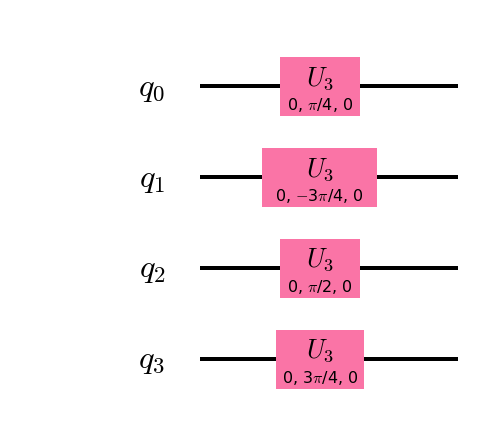

In [125]:
qcp = QuantumCircuit(num_qbit)
for i in range(num_qbit):
    qcp.u3(0,single_qbit_shift[i],0,i)

qcp.draw(output='mpl')

Let's execute it and check its diagonal.  
We care only about the diagonal because the circuit is going to generate a matrix where all the rest of the values are 0

In [180]:
result = execute(qcp, backend = U_simulator).result()
P = result.get_unitary()
P_diag = np.diagonal(P)
P_diag = np.around(P_diag, 8)
P_diag_rational = vnsimplify(P_diag, constants=[sym.sqrt(2), sym.pi])
display(sym.Matrix(np.matrix([P_diag_rational])))

⎡   √2   √2⋅ⅈ    √2   √2⋅ⅈ           √2   √2⋅ⅈ  √2   √2⋅ⅈ       √2   √2⋅ⅈ     
⎢1  ── + ────  - ── - ────  -ⅈ  ⅈ  - ── + ────  ── - ────  1  - ── + ────  -1 
⎣   2     2      2     2             2     2    2     2         2     2       

    √2   √2⋅ⅈ    √2   √2⋅ⅈ           √2   √2⋅ⅈ⎤
 1  ── + ────  - ── - ────  -ⅈ  ⅈ  - ── + ────⎥
    2     2      2     2             2     2  ⎦

And again by rewriting them in polar form and considering only $\theta$

In [137]:
P_diag_phases = np.angle(P_diag)
P_diag_phases_rational = vnsimplify(P_diag_phases, constants=[sym.sqrt(2), sym.pi])
display(sym.Matrix(np.matrix([P_diag_phases_rational])))

⎡   π  -3⋅π   -π   π  3⋅π  -π      3⋅π        π  -3⋅π   -π   π  3⋅π⎤
⎢0  ─  ─────  ───  ─  ───  ───  0  ───  π  0  ─  ─────  ───  ─  ───⎥
⎣   4    4     2   2   4    4       4         4    4     2   2   4 ⎦

It seems we're very close with HUH. If we subtrack P to HUH we can see how close we are

In [181]:
phase_diff = m_rad_sum(P_diag_phases_rational, HUH_diag_phases_rational * -1)
display(sym.Matrix(np.matrix([phase_diff])))

[0  0  0  π  0  π  π  π  0  0  π  0  0  π  0  0]

We're so close! we have a circuit causing the exact phase shift (where we see 0) or is off by $\pi$  
We can use z gates to conditionally compensate those $\pi$.  
If we put in a table all the possible states we can see across which qbits we need to apply a cz gate.

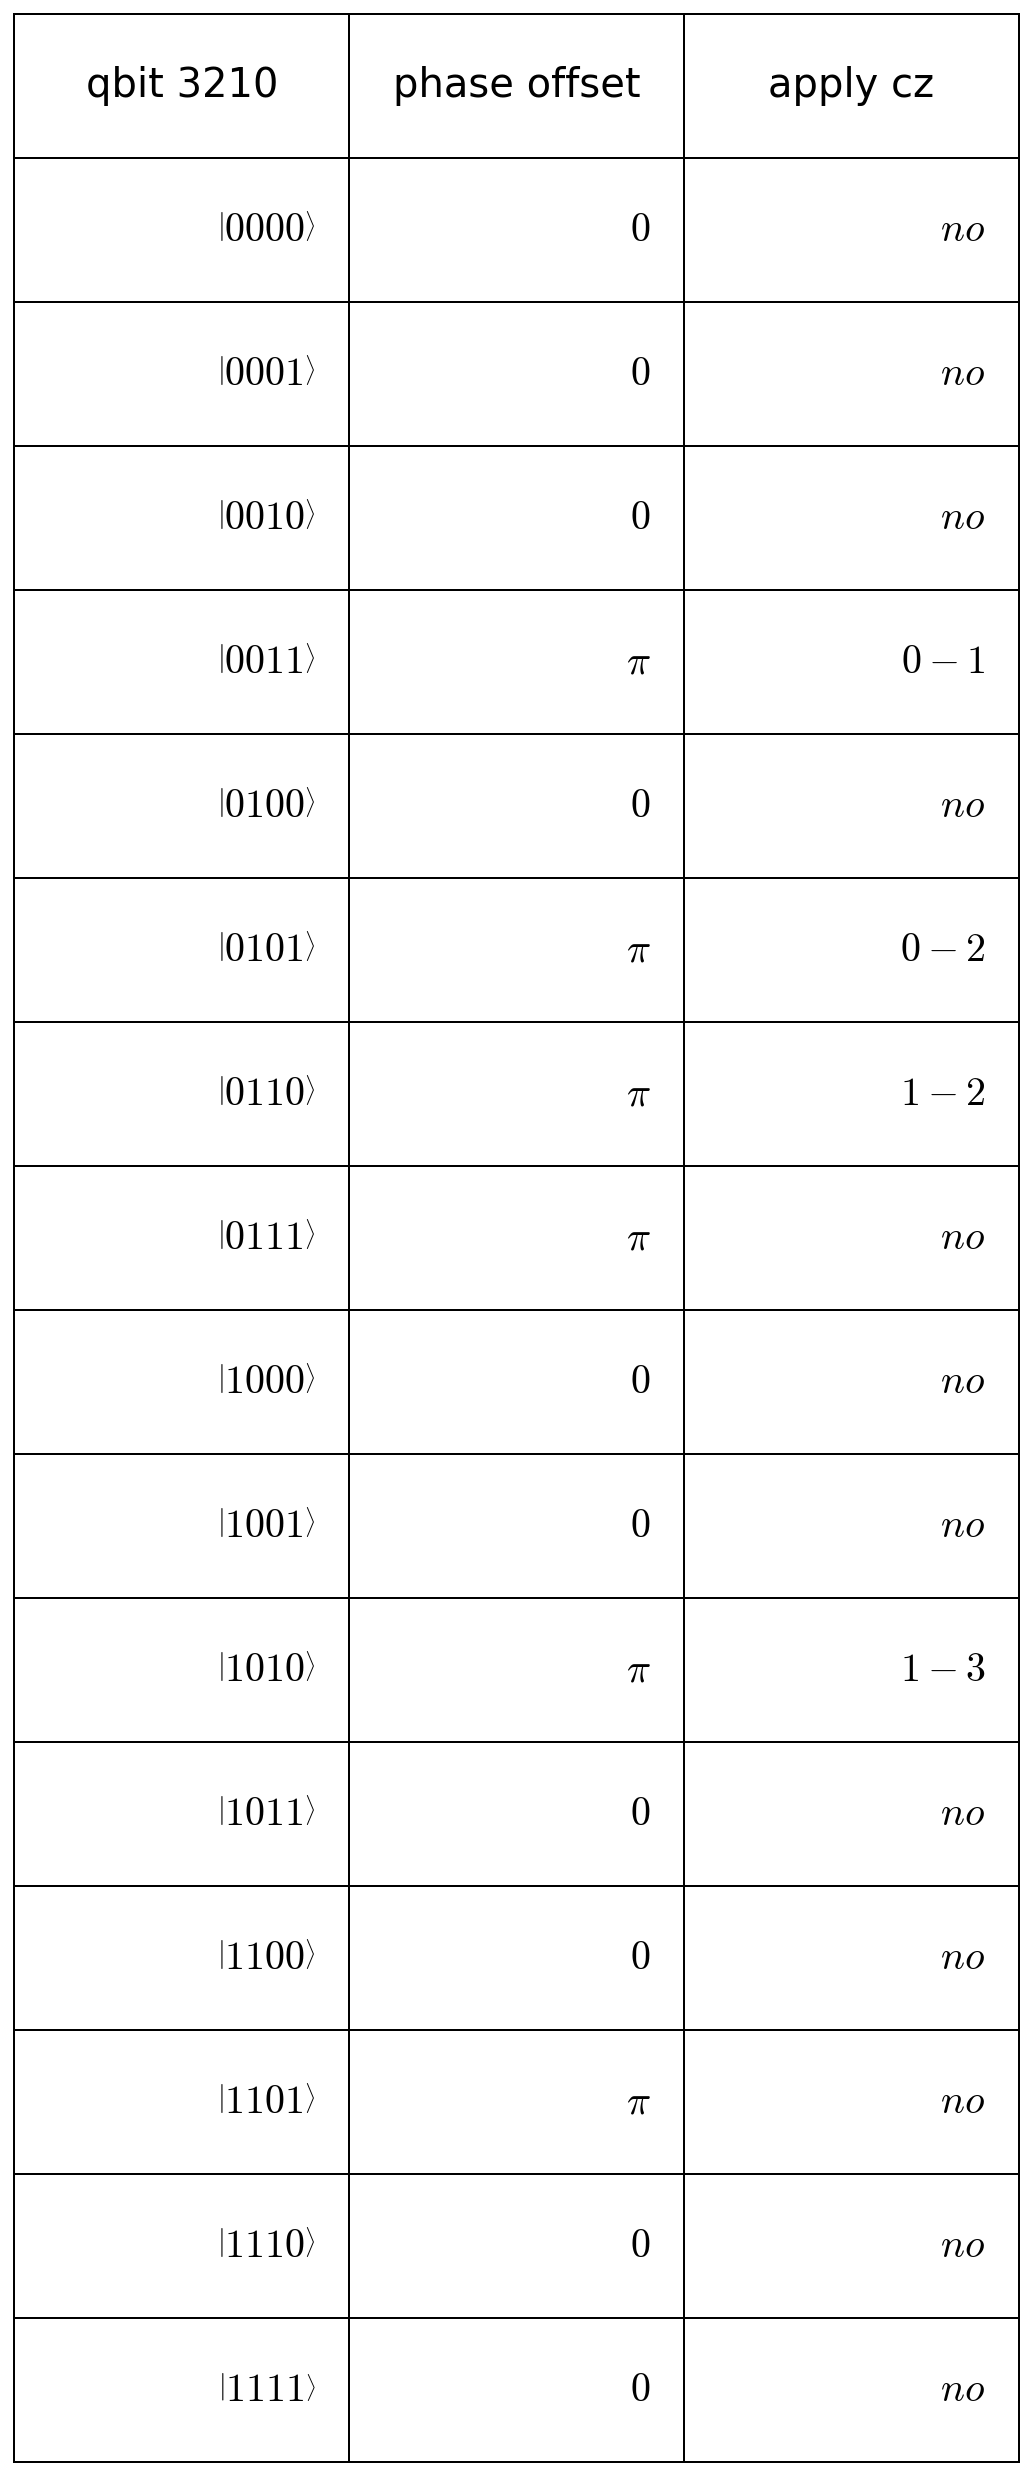

In [191]:
qbits_needing_cz = []
for idx in range(len(phase_diff)):
    phase = phase_diff[idx]
    if bin(idx).count("1") == 2 and phase == sym.pi:
        bits = []
        for i, c in enumerate(bin(idx)[:1:-1], 0):
            if c == '1':
                bits.append(i)
        qbits_needing_cz.append(bits)
#print(qbits_needing_cz)

table_data = []
for idx, phase in enumerate(phase_diff):
    ketval = idx
    ket_args = [int(x) for x in '{:04b}'.format(ketval)]
    ket_val = Ket(*ket_args)
    ket_val_latex = r"${}$".format(sym.latex(ket_val))
    phase_latex = r"${}$".format(sym.latex(phase))
    result_latex = r"$no$"
    if bin(idx).count("1") == 2 and phase == sym.pi:
        bits = []
        for i, c in enumerate(bin(idx)[:1:-1], 0):
            if c == '1':
                bits.append(i)
        result_latex = r"${} - {}$".format(bits[0], bits[1])
    table_data.append([ket_val_latex, phase_latex, result_latex])

collabel=("qbit 3210", "phase offset", "apply cz")
gen_table(table_data, collabel, figsize=(3,6), font_size=20, table_scale=(3,6))
plt.show()

Note: for state 0111 and 1101 we are not applying a cz gate. This is because another cz gate is taking care of applying the phase shift.  
0111 should be 0-1-2 but we already have a cz gate across 0-1 and 0-2.  
1101 should be 0-2-3 but we already have a cz gate across 0-2.

We can create the following circuit from the above table.  
We're adding some barriers to see better how the circuits looks like when we print it

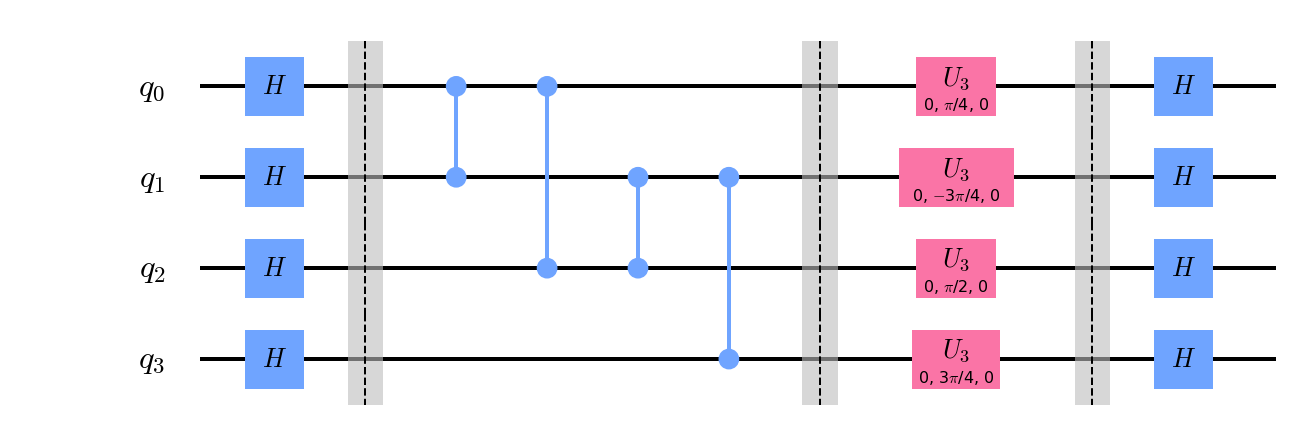

In [188]:
def optimized4():
    qc = QuantumCircuit(num_qbit)
    qc.h(num_qbit_list)
    qc.barrier()
    for qbits in qbits_needing_cz:
        qc.cz(qbits[0], qbits[1])
    qc.barrier()
    for i in range(num_qbit):
        qc.u3(0,single_qbit_shift[i],0,i)
    qc.barrier()
    qc.h(num_qbit_list)
    return qc

qc = optimized4()
qc.draw(output='mpl')

We can try to remove the barriers, feed it to the transpiler and check our score!

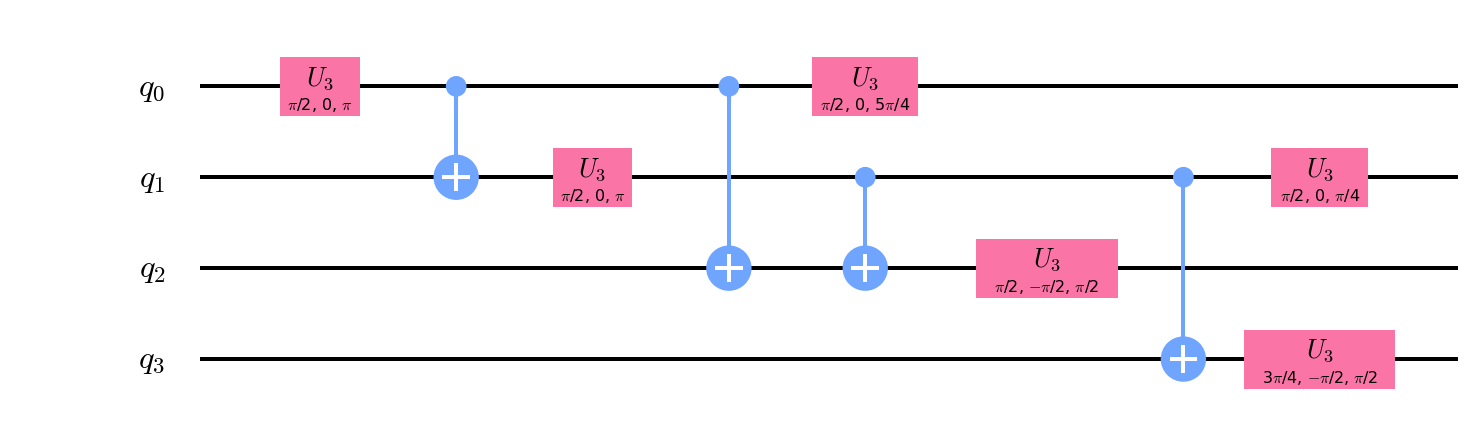

In [189]:
def optimized5():
    qc = QuantumCircuit(num_qbit)
    qc.h(num_qbit_list)
    for qbits in qbits_needing_cz:
        qc.cz(qbits[0], qbits[1])
    for i in range(num_qbit):
        qc.u3(0,single_qbit_shift[i],0,i)
    qc.h(num_qbit_list)
    qc_t = transpile(qc, basis_gates = ['u3', 'cx'], optimization_level=3)
    
    return qc_t

qc = optimized5()
qc.draw(output='mpl')

In [157]:
check_circuit(qc5_transpiled)

Circuit stats:
||U-V||_2 = 1.4545997371336805e-15
(U is the reference unitary, V is yours, and the global phase has been removed from both of them).
Cost is 46

Great! Your circuit meets all the constrains.
Your score is 46. The lower, the better!
Feel free to submit your answer and remember you can re-submit a new circuit at any time!


Well done!  
Another approach which allowed Luciano Pereira Valenzuela to achieve the lowest found score of 45 is the following.  
In his words from the #ibm-quantum-challenge slack channel:  
> I multiplied gates to U in order to obtain the identity.
I did this per qubit, that's, first I transformed U to I kron V,
and then I repeat per qubit. Finally, 
I reduce the circuit size combining u3 gates and employing a c-not identity.

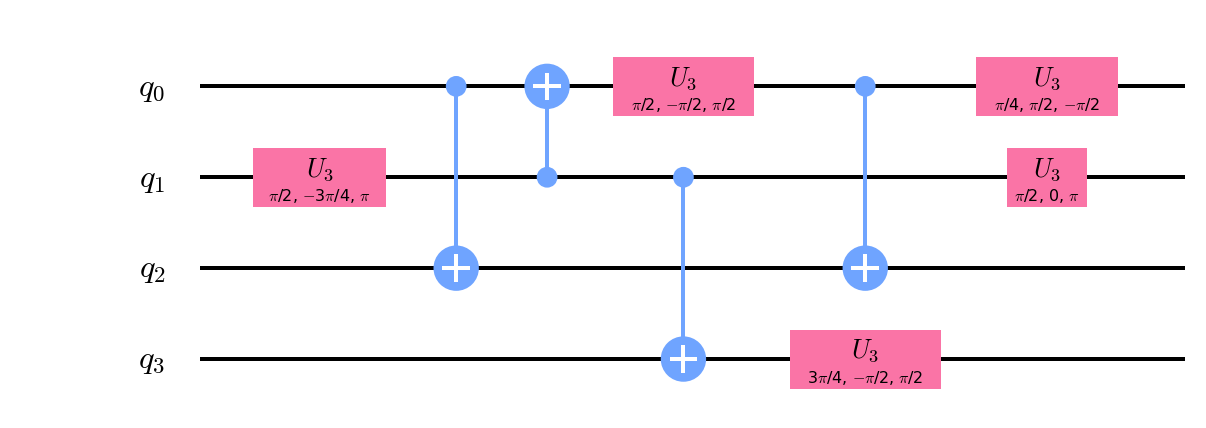

In [186]:
def optimized6():
    qc = QuantumCircuit(4)
    qc.u3(np.pi/2,-3*np.pi/4,np.pi,1)
    qc.cx(0, 2)
    qc.cx(1, 0)
    qc.u3(np.pi/2,-np.pi/2,np.pi/2,0)
    qc.cx(1, 3)
    qc.cx(0, 2)
    qc.u3(3*np.pi/4,-np.pi/2,np.pi/2,3)
    qc.u3(np.pi/4,np.pi/2,-np.pi/2,0)
    qc.u3(np.pi/2,0,np.pi,1)
    qc_t = transpile(qc, basis_gates = ['u3', 'cx'], optimization_level=3)

    return qc_t

qc = optimized6()
qc.draw(output='mpl')

In [161]:
check_circuit(qc)

Circuit stats:
||U-V||_2 = 1.3705158712462245e-15
(U is the reference unitary, V is yours, and the global phase has been removed from both of them).
Cost is 45

Great! Your circuit meets all the constrains.
Your score is 45. The lower, the better!
Feel free to submit your answer and remember you can re-submit a new circuit at any time!


What can we say? Amazing!

You can check whether your circuit is valid before submitting it with `check_circuit(qc)`. Once you have a valid solution, please submit it by running the following cell (delete the `#` before `submit_circuit`). You can re-submit at any time.


In [ ]:
# Send the circuit as the final answer, can re-submit at any time
#submit_circuit(qc) 